In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

# Load and Prepare the MNIST Dataset

In [2]:
# Load MNIST dataset
(X_train, _), (X_test, _) = mnist.load_data()

# Normalize the images
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

# Reshape the images to add a channel dimension
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))

# Add random noise to the images
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Clip the values to be between 0 and 1
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

# Visualize Noisy Images

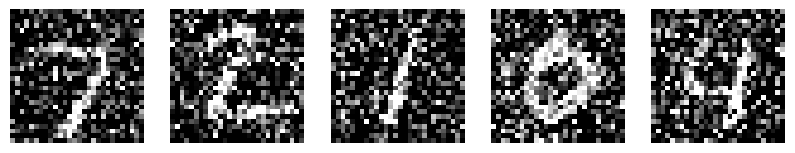

In [3]:
# Display a few noisy images
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

# Build the Autoencoder Model

In [4]:
def build_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = Model(input_img, decoded)
    return autoencoder

# Build the model
autoencoder = build_autoencoder()

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the Model

In [5]:
# Train the autoencoder
history = autoencoder.fit(X_train_noisy, X_train,
                          epochs=10,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(X_test_noisy, X_test))

Epoch 1/10
469/469 [==============================] - 245s 519ms/step - loss: 0.1497 - val_loss: 0.1109
Epoch 2/10
469/469 [==============================] - 243s 518ms/step - loss: 0.1081 - val_loss: 0.1039
Epoch 3/10
469/469 [==============================] - 241s 514ms/step - loss: 0.1033 - val_loss: 0.1008
Epoch 4/10
469/469 [==============================] - 241s 514ms/step - loss: 0.1009 - val_loss: 0.0995
Epoch 5/10
469/469 [==============================] - 242s 515ms/step - loss: 0.0994 - val_loss: 0.0980
Epoch 6/10
469/469 [==============================] - 241s 515ms/step - loss: 0.0983 - val_loss: 0.0975
Epoch 7/10
469/469 [==============================] - 238s 508ms/step - loss: 0.0975 - val_loss: 0.0963
Epoch 8/10
469/469 [==============================] - 232s 493ms/step - loss: 0.0968 - val_loss: 0.0959
Epoch 9/10
469/469 [==============================] - 238s 507ms/step - loss: 0.0962 - val_loss: 0.0954
Epoch 10/10
469/469 [==============================] - 235s 502m

# Visualize Denoising Results on Test Data

313/313 [==============================] - 3s 10ms/step


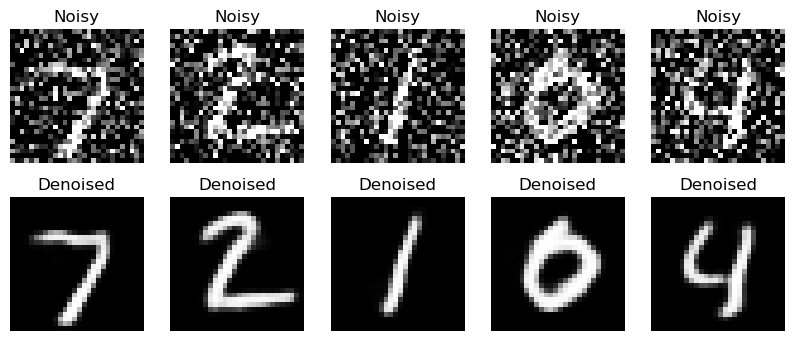

In [7]:
# Predict the denoised images
decoded_imgs = autoencoder.predict(X_test_noisy)

# Display original noisy and denoised images
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    # Display noisy image
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Display denoised image
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

plt.show()

# Test Denoising on an External Image

In [ ]:
from skimage import io, color, img_as_float
from skimage.transform import resize

# Load external image and add noise
external_img = io.imread('image.png')  # Load an external image
external_img = color.rgb2gray(external_img)  # Convert to grayscale
external_img = resize(external_img, (28, 28))  # Resize to 28x28
external_img = img_as_float(external_img)

# Add noise
external_img_noisy = external_img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=external_img.shape)
external_img_noisy = np.clip(external_img_noisy, 0., 1.)

# Reshape to match model input shape
external_img_noisy = np.reshape(external_img_noisy, (1, 28, 28, 1))

# Denoise using the model
external_img_denoised = autoencoder.predict(external_img_noisy)

# Display noisy and denoised images
plt.figure(figsize=(6, 3))

# Noisy image
plt.subplot(1, 2, 1)
plt.imshow(external_img_noisy.reshape(28, 28), cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

# Denoised image
plt.subplot(1, 2, 2)
plt.imshow(external_img_denoised.reshape(28, 28), cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

plt.show()